Решим задачу мультиклассовой классификации с помощью свёрточной нейросети, определяя, какому художнику принадлежит картина по её фрагменту (тк все картины разного формата, определим минимальный размер фрагмента и обрежем по нему), используя датасет по ссылке: https://www.kaggle.com/datasets/downshift/russian-classic-painting-dataset

# Обработка данных

In [ ]:
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

from sklearn.metrics import accuracy_score

In [ ]:
!pwd

/content


In [ ]:
!unzip '/content/archive.zip'

Archive:  /content/archive.zip
replace data/100549316.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Обработаем лейблы - художников, из таблицы с информацией, и сопоставим файлу художника в словаре.

In [ ]:
import csv

rows = []

with open('/content/description.csv') as f:
  reader = csv.reader(f)
  fields = next(reader)
  for row in reader:
    rows.append(row)

print(*fields)
print(rows[:5])

filename ru_title ru_author gpt_description eng_title eng_author
[['./data/845010375.jpg', 'Золотая осень', 'Исаак Ильич Левитан', 'a painting of a river in the fall', 'Golden Autumn', 'Isaac Ilyich Levittan'], ['./data/669860839.jpg', 'Поздняя осень', 'Исаак Ильич Левитан', 'a painting of a field with a barn in the background', 'Late autumn', 'Isaac Ilyich Levittan'], ['./data/741052246.jpg', 'Зимой в лесу. 1885', 'Исаак Ильич Левитан', 'a painting of a deer in the snow', 'In winter in the woods. 1885', 'Isaac Ilyich Levittan'], ['./data/884368896.jpg', 'Март', 'Исаак Ильич Левитан', 'a painting of a snowy scene with a house and a horse', 'March', 'Isaac Ilyich Levittan'], ['./data/628277587.jpg', 'Вечерние тени. 1891-1894', 'Исаак Ильич Левитан', 'a painting of a green field with trees and water', 'Evening shadows. 1891-1894', 'Isaac Ilyich Levittan']]


In [ ]:
file2art = {}
for row in rows:
    file2art[row[0][1:]] = row[2]

Обработаем изображения - найдём минимальный общий фрагмент и обрежем по нему, преобразауем в нужный тип, а также составим соответсвующий массиву изображений массив авторов.

In [ ]:
import glob
import os
from PIL import Image
import numpy as np

file_list = glob.glob(os.path.join(os.getcwd(), "/content/data/", "*.jpg"))
imgs = []
artists = []
mn_width = 0
mn_height = 0

for file_path in file_list:
  if file_path[8:] in file2art:
    img = Image.open(file_path)
    np_img = np.array(img)
    imgs.append(np_img)
    artists.append(file2art[file_path[8:]])

    if np_img.shape[0] < mn_height or mn_height == 0:
      mn_height = np_img.shape[0]
    if np_img.shape[1] < mn_width or mn_width == 0:
      mn_width = np_img.shape[1]

print(mn_height, mn_width)

160 233


In [ ]:
for i in range(len(imgs)):
  imgs[i] = np.transpose(imgs[i][:mn_height, :mn_width, :], (2, 0, 1))

In [ ]:
imgs = torch.tensor(np.asarray(imgs))

In [ ]:
imgs = imgs.type(torch.float32)

In [ ]:
imgs.shape

torch.Size([1670, 3, 160, 233])

Обработаем авторов - пронумеруем классы.

In [ ]:
art2num = {}
num2art = {}
total = 0
labels = []
for name in artists:
  if not name in art2num:
    art2num[name] = total
    num2art[total] = name
    labels.append(total)
    total += 1
  else:
    labels.append(art2num[name])

In [ ]:
print(total)

6


In [ ]:
labels = torch.tensor(labels)

Подготовим данные к обучению - разделим на обучающие и тестовые, а также поделим на батчи.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(imgs.numpy(), labels.numpy(), test_size=0.3, random_state=42)
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

In [ ]:
class DataSet:
    def __init__(self, imgs, labels):
        self.imgs = imgs
        self.labels = labels

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        label = self.labels[idx]
        return img, label

In [ ]:
train_data = DataSet(X_train, y_train)
test_data = DataSet(X_test, y_test)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:
def trainAdam(net, n_ep=5, l_r=0.001):
  loss_fn = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters(), lr=l_r)

  for ep in tqdm_notebook(range(n_ep)):
    losses = 0.
    train_dataiter = iter(train_loader)

    for i, batch in enumerate(tqdm_notebook(train_dataiter)):
      X_b, y_b = batch

      optimizer.zero_grad()
      y_pred = net(X_b)
      loss_b = loss_fn(y_pred, y_b)

      loss_b.backward()
      optimizer.step()
      losses += loss_b

      if i % 10 == 9:
        print('[%d %5d] loss: %.3f' % (ep + 1, i + 1, losses / 10))
        losses = 0

  print("ready")
  return net

def trainSGD(net, n_ep=5, l_r=0.001):
  loss_fn = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(net.parameters(), lr=l_r)

  for ep in tqdm_notebook(range(n_ep)):
    losses = 0.
    train_dataiter = iter(train_loader)

    for i, batch in enumerate(tqdm_notebook(train_dataiter)):
      X_b, y_b = batch

      optimizer.zero_grad()
      y_pred = net(X_b)
      loss_b = loss_fn(y_pred, y_b)

      loss_b.backward()
      optimizer.step()
      losses += loss_b

      if i % 10 == 9:
        print('[%d %5d] loss: %.3f' % (ep + 1, i + 1, losses / 10))
        losses = 0

  print("ready")
  return net

# Первичная простейшая архитектура, число эпох, оптимизатор

In [ ]:
class ToVect(nn.Module):
  def forward(self, img):
    return img.view(img.size(0), -1)

class CNN_0(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 20, kernel_size=3)
    self.conv2 = nn.Conv2d(20, 3, kernel_size=3)
    self.toVec = ToVect()
    self.fc = nn.Linear((mn_height-4)*(mn_width-4)*3, 6)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.toVec(x)
    x = F.softmax(self.fc(x))
    return x

2 функции обучения - с Adam и SGD в качестве оптимизаторов.

In [ ]:
def trainAdam(net, n_ep=5, l_r=0.001):
  loss_fn = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters(), lr=l_r)

  for ep in tqdm_notebook(range(n_ep)):
    losses = 0.
    train_dataiter = iter(train_loader)

    for i, batch in enumerate(tqdm_notebook(train_dataiter)):
      X_b, y_b = batch

      optimizer.zero_grad()
      y_pred = net(X_b)
      loss_b = loss_fn(y_pred, y_b)

      loss_b.backward()
      optimizer.step()
      losses += loss_b

      if i % 10 == 9:
        print('[%d %5d] loss: %.3f' % (ep + 1, i + 1, losses / 10))
        losses = 0

  print("ready")
  return net

def trainSGD(net, n_ep=5, l_r=0.001):
  loss_fn = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(net.parameters(), lr=l_r)

  for ep in tqdm_notebook(range(n_ep)):
    losses = 0.
    train_dataiter = iter(train_loader)

    for i, batch in enumerate(tqdm_notebook(train_dataiter)):
      X_b, y_b = batch

      optimizer.zero_grad()
      y_pred = net(X_b)
      loss_b = loss_fn(y_pred, y_b)

      loss_b.backward()
      optimizer.step()
      losses += loss_b

      if i % 10 == 9:
        print('[%d %5d] loss: %.3f' % (ep + 1, i + 1, losses / 10))
        losses = 0

  print("ready")
  return net

Прообучаемся 3, 5, 10 эпох с батчами размера 64.

In [ ]:
net = CNN_0()
net = trainAdam(net, 3)

test_dataiter = iter(test_loader)
img, labels = next(test_dataiter)

print("ACCURACY:")
accuracy_score(labels.numpy(), np.argmax(net.forward(img).detach().numpy(), axis=1))

<ipython-input-42-7c19709f3ad3>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ep in tqdm_notebook(range(n_ep)):


  0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-42-7c19709f3ad3>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_dataiter)):


  0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-46-b094d1c82efd>:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc(x))


[1    10] loss: 1.799


  0%|          | 0/19 [00:00<?, ?it/s]

[2    10] loss: 1.803


  0%|          | 0/19 [00:00<?, ?it/s]

[3    10] loss: 1.784
ready
ACCURACY:


0.3125

In [ ]:
net = CNN_0()
net = trainAdam(net, 5)

test_dataiter = iter(test_loader)
img, labels = next(test_dataiter)

print("ACCURACY:")
accuracy_score(labels.numpy(), np.argmax(net.forward(img).detach().numpy(), axis=1))

<ipython-input-42-7c19709f3ad3>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ep in tqdm_notebook(range(n_ep)):


  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-42-7c19709f3ad3>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_dataiter)):


  0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-46-b094d1c82efd>:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc(x))


[1    10] loss: 1.745


  0%|          | 0/19 [00:00<?, ?it/s]

[2    10] loss: 1.717


  0%|          | 0/19 [00:00<?, ?it/s]

[3    10] loss: 1.714


  0%|          | 0/19 [00:00<?, ?it/s]

[4    10] loss: 1.723


  0%|          | 0/19 [00:00<?, ?it/s]

[5    10] loss: 1.728
ready
ACCURACY:


0.328125

In [ ]:
net = CNN_0()
net = trainAdam(net, 10)

test_dataiter = iter(test_loader)
img, labels = next(test_dataiter)

print("ACCURACY:")
accuracy_score(labels.numpy(), np.argmax(net.forward(img).detach().numpy(), axis=1))

<ipython-input-42-7c19709f3ad3>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ep in tqdm_notebook(range(n_ep)):


  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-42-7c19709f3ad3>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_dataiter)):


  0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-46-b094d1c82efd>:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc(x))


[1    10] loss: 1.737


  0%|          | 0/19 [00:00<?, ?it/s]

[2    10] loss: 1.635


  0%|          | 0/19 [00:00<?, ?it/s]

[3    10] loss: 1.617


  0%|          | 0/19 [00:00<?, ?it/s]

[4    10] loss: 1.545


  0%|          | 0/19 [00:00<?, ?it/s]

[5    10] loss: 1.496


  0%|          | 0/19 [00:00<?, ?it/s]

[6    10] loss: 1.441


  0%|          | 0/19 [00:00<?, ?it/s]

[7    10] loss: 1.421


  0%|          | 0/19 [00:00<?, ?it/s]

[8    10] loss: 1.375


  0%|          | 0/19 [00:00<?, ?it/s]

[9    10] loss: 1.336


  0%|          | 0/19 [00:00<?, ?it/s]

[10    10] loss: 1.293
ready
ACCURACY:


0.328125

Как мы видим, с увеличением числа эпох после 5 эпох качество модели не улучшается. Попробуем обучить на 5 эпохах с размером батчей 16 с помощью Adam и SGD.

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False)

In [ ]:
net = CNN_0()
net = trainAdam(net, 5)

test_dataiter = iter(test_loader)
img, labels = next(test_dataiter)

print("ACCURACY:")
accuracy_score(labels.numpy(), np.argmax(net.forward(img).detach().numpy(), axis=1))

<ipython-input-42-7c19709f3ad3>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ep in tqdm_notebook(range(n_ep)):


  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-42-7c19709f3ad3>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_dataiter)):


  0%|          | 0/74 [00:00<?, ?it/s]

<ipython-input-46-b094d1c82efd>:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc(x))


[1    10] loss: 1.850
[1    20] loss: 1.669
[1    30] loss: 1.756
[1    40] loss: 1.769
[1    50] loss: 1.731
[1    60] loss: 1.737
[1    70] loss: 1.706


  0%|          | 0/74 [00:00<?, ?it/s]

[2    10] loss: 1.762
[2    20] loss: 1.700
[2    30] loss: 1.712
[2    40] loss: 1.694
[2    50] loss: 1.687
[2    60] loss: 1.775
[2    70] loss: 1.725


  0%|          | 0/74 [00:00<?, ?it/s]

[3    10] loss: 1.706
[3    20] loss: 1.750
[3    30] loss: 1.762
[3    40] loss: 1.700
[3    50] loss: 1.706
[3    60] loss: 1.787
[3    70] loss: 1.675


  0%|          | 0/74 [00:00<?, ?it/s]

[4    10] loss: 1.750
[4    20] loss: 1.719
[4    30] loss: 1.731
[4    40] loss: 1.744
[4    50] loss: 1.687
[4    60] loss: 1.687
[4    70] loss: 1.769


  0%|          | 0/74 [00:00<?, ?it/s]

[5    10] loss: 1.812
[5    20] loss: 1.737
[5    30] loss: 1.681
[5    40] loss: 1.762
[5    50] loss: 1.725
[5    60] loss: 1.669
[5    70] loss: 1.706
ready
ACCURACY:


0.3125

In [ ]:
net = CNN_0()
net = trainSGD(net, 5)

test_dataiter = iter(test_loader)
img, labels = next(test_dataiter)

print("ACCURACY:")
accuracy_score(labels.numpy(), np.argmax(net.forward(img).detach().numpy(), axis=1))

<ipython-input-42-7c19709f3ad3>:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ep in tqdm_notebook(range(n_ep)):


  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-42-7c19709f3ad3>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_dataiter)):


  0%|          | 0/74 [00:00<?, ?it/s]

<ipython-input-46-b094d1c82efd>:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc(x))


[1    10] loss: 1.923
[1    20] loss: 1.944
[1    30] loss: 1.919
[1    40] loss: 1.950
[1    50] loss: 1.925
[1    60] loss: 1.931
[1    70] loss: 1.950


  0%|          | 0/74 [00:00<?, ?it/s]

[2    10] loss: 1.912
[2    20] loss: 1.925
[2    30] loss: 1.969
[2    40] loss: 1.931
[2    50] loss: 1.906
[2    60] loss: 1.950
[2    70] loss: 1.944


  0%|          | 0/74 [00:00<?, ?it/s]

[3    10] loss: 1.969
[3    20] loss: 1.894
[3    30] loss: 1.925
[3    40] loss: 1.925
[3    50] loss: 1.962
[3    60] loss: 1.931
[3    70] loss: 1.925


  0%|          | 0/74 [00:00<?, ?it/s]

[4    10] loss: 1.937
[4    20] loss: 1.956
[4    30] loss: 1.937
[4    40] loss: 1.937
[4    50] loss: 1.950
[4    60] loss: 1.869
[4    70] loss: 1.969


  0%|          | 0/74 [00:00<?, ?it/s]

[5    10] loss: 1.887
[5    20] loss: 1.931
[5    30] loss: 1.969
[5    40] loss: 1.975
[5    50] loss: 1.950
[5    60] loss: 1.919
[5    70] loss: 1.912
ready
ACCURACY:


0.125

Изменение размера батчей при использовании Adam не повлияло на результат незначительно в худшую сторону, использование SGD значительно ухудшило качество, поэтому далее будем обучать 5 эпох с использованием Adam батчами размера 64.

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

# Обработка входных данных с помощью SVD

Предположим, сколько компонент можно оставить, посчитав средние значения сингулярных значений и определив, сколько первых вносят наибольший вклад.

In [ ]:
from numpy.linalg import svd

flag = False

for img in imgs:
  U, S, VT = svd(img.numpy().astype(float), full_matrices=False)
  if not flag:
    sigmas = S
    flag = True
  else:
    s_len = sigmas.shape[1]
    S_len = S.shape[1]
    max_len = max(s_len, S_len)
    sigmas = np.concatenate((sigmas, np.reshape(np.zeros(3 * (max_len - s_len)), (3, max_len - s_len))), axis=1)
    S = np.concatenate((S, np.reshape(np.zeros(3 * (max_len - S_len)), (3, max_len - S_len))), axis=1)
    sigmas = sigmas + S

sigmas = sigmas / len(artists)

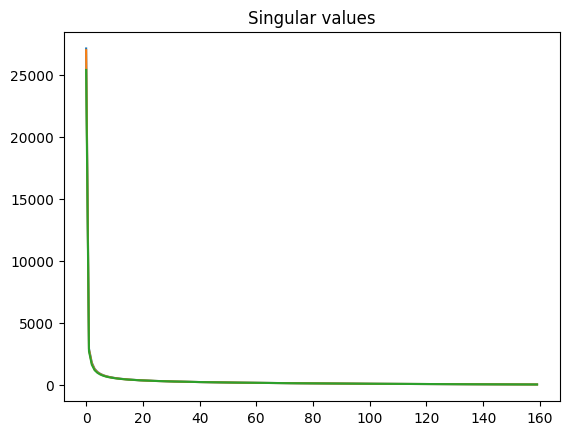

In [ ]:
plt.title("Singular values")
plt.plot(sigmas[0, :])
plt.plot(sigmas[1, :])
plt.plot(sigmas[2, :])

Таким образом, должно быть достаточно оставить первые 10 сингулярных комопнент.

In [ ]:
imgs_svd = []

for img in imgs:
  U, S, VT = svd(img.numpy().astype(float), full_matrices=False)
  U = U[:, :, :10]
  S = S[:, :10]
  VT = VT[:, :10, :]
  imgs_svd.append(np.matmul(U * S[..., None, :], VT))

imgs_svd = torch.tensor(np.asarray(imgs_svd))
imgs_svd = imgs_svd.type(torch.float32)

In [ ]:
labels_svd = []
for name in artists:
  labels_svd.append(art2num[name])
labels_svd = torch.tensor(labels_svd)
labels_svd.shape

torch.Size([1670])

In [ ]:
X_train_svd, X_test_svd, y_train_svd, y_test_svd = train_test_split(imgs_svd.numpy(), labels_svd.numpy(), test_size=0.3, random_state=42)
X_train_svd = torch.tensor(X_train_svd)
X_test_svd = torch.tensor(X_test_svd)
y_train_svd = torch.tensor(y_train_svd)
y_test_svd = torch.tensor(y_test_svd)

In [ ]:
train_data_svd = DataSet(X_train_svd, y_train_svd)
test_data_svd = DataSet(X_test_svd, y_test_svd)

In [ ]:
train_loader_svd = torch.utils.data.DataLoader(train_data_svd, batch_size=64, shuffle=True)
test_loader_svd = torch.utils.data.DataLoader(test_data_svd, batch_size=64, shuffle=False)

In [ ]:
def train_svd(net, n_ep=5, l_r=0.001):
  loss_fn = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters(), lr=l_r)

  for ep in tqdm_notebook(range(n_ep)):
    losses = 0.
    train_dataiter = iter(train_loader_svd)

    for i, batch in enumerate(tqdm_notebook(train_dataiter)):
      X_b, y_b = batch

      optimizer.zero_grad()
      y_pred = net(X_b)
      loss_b = loss_fn(y_pred, y_b)

      loss_b.backward()
      optimizer.step()
      losses += loss_b

      if i % 10 == 9:
        print('[%d %5d] loss: %.3f' % (ep + 1, i + 1, losses / 10))
        losses = 0

  print("ready")
  return net

In [ ]:
net = CNN_0()
net = train_svd(net, 5)

test_dataiter_svd = iter(test_loader_svd)
img, labels = next(test_dataiter_svd)

print("ACCURACY:")
accuracy_score(labels.numpy(), np.argmax(net.forward(img).detach().numpy(), axis=1))

<ipython-input-93-8da0a167bd6b>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ep in tqdm_notebook(range(n_ep)):


  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-93-8da0a167bd6b>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_dataiter)):


  0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-46-b094d1c82efd>:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc(x))


[1    10] loss: 1.729


  0%|          | 0/19 [00:00<?, ?it/s]

[2    10] loss: 1.748


  0%|          | 0/19 [00:00<?, ?it/s]

[3    10] loss: 1.706


  0%|          | 0/19 [00:00<?, ?it/s]

[4    10] loss: 1.737


  0%|          | 0/19 [00:00<?, ?it/s]

[5    10] loss: 1.715
ready
ACCURACY:


0.375

Это улучшило качество работы модели, так что далее будем использовать данные, обработанные с помощью SVD.

# Свёрточные слои

Добавим ещё один слой.

In [ ]:
class ToVect(nn.Module):
  def forward(self, img):
    return img.view(img.size(0), -1)

class CNN_1(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 10, kernel_size=3)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
    self.conv3 = nn.Conv2d(20, 3, kernel_size=3)
    self.toVec = ToVect()
    self.fc = nn.Linear((mn_height-6)*(mn_width-6)*3, 6)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = self.toVec(x)
    x = F.softmax(self.fc(x))
    return x

In [ ]:
net = CNN_1()
net = train_svd(net, 5)

test_dataiter_svd = iter(test_loader_svd)
img, labels = next(test_dataiter_svd)

print("ACCURACY:")
accuracy_score(labels.numpy(), np.argmax(net.forward(img).detach().numpy(), axis=1))

<ipython-input-93-8da0a167bd6b>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ep in tqdm_notebook(range(n_ep)):


  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-93-8da0a167bd6b>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_dataiter)):


  0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-95-92796bdfd918>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc(x))


[1    10] loss: 1.788


  0%|          | 0/19 [00:00<?, ?it/s]

[2    10] loss: 1.728


  0%|          | 0/19 [00:00<?, ?it/s]

[3    10] loss: 1.712


  0%|          | 0/19 [00:00<?, ?it/s]

[4    10] loss: 1.730


  0%|          | 0/19 [00:00<?, ?it/s]

[5    10] loss: 1.733
ready
ACCURACY:


0.328125

Стало хуже. Изменим размер ядра.

In [ ]:
class ToVect(nn.Module):
  def forward(self, img):
    return img.view(img.size(0), -1)

class CNN_2(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 20, kernel_size=7)
    self.conv2 = nn.Conv2d(20, 3, kernel_size=7)
    self.toVec = ToVect()
    self.fc = nn.Linear((mn_height-12)*(mn_width-12)*3, 6)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.toVec(x)
    x = F.softmax(self.fc(x))
    return x

In [ ]:
net = CNN_2()
net = train_svd(net, 5)

test_dataiter_svd = iter(test_loader_svd)
img, labels = next(test_dataiter_svd)

print("ACCURACY:")
accuracy_score(labels.numpy(), np.argmax(net.forward(img).detach().numpy(), axis=1))

<ipython-input-93-8da0a167bd6b>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ep in tqdm_notebook(range(n_ep)):


  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-93-8da0a167bd6b>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_dataiter)):


  0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-100-15d5f84d33f7>:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc(x))


[1    10] loss: 1.742


  0%|          | 0/19 [00:00<?, ?it/s]

[2    10] loss: 1.730


  0%|          | 0/19 [00:00<?, ?it/s]

[3    10] loss: 1.736


  0%|          | 0/19 [00:00<?, ?it/s]

[4    10] loss: 1.717


  0%|          | 0/19 [00:00<?, ?it/s]

[5    10] loss: 1.737
ready
ACCURACY:


0.328125

Тоже стало хуже.

# Линейные слои

Добавим линейный слой

In [ ]:
class ToVect(nn.Module):
  def forward(self, img):
    return img.view(img.size(0), -1)

class CNN_3(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 20, kernel_size=3)
    self.conv2 = nn.Conv2d(20, 3, kernel_size=3)
    self.toVec = ToVect()
    self.fc1 = nn.Linear((mn_height-4)*(mn_width-4)*3, 1000)
    self.fc2 = nn.Linear(1000, 6)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.toVec(x)
    x = F.softmax(self.fc1(x))
    x = F.softmax(self.fc2(x))
    return x

In [ ]:
net = CNN_3()
net = train_svd(net, 7)

test_dataiter_svd = iter(test_loader_svd)
img, labels = next(test_dataiter_svd)

print("ACCURACY:")
accuracy_score(labels.numpy(), np.argmax(net.forward(img).detach().numpy(), axis=1))

<ipython-input-93-8da0a167bd6b>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ep in tqdm_notebook(range(n_ep)):


  0%|          | 0/7 [00:00<?, ?it/s]

<ipython-input-93-8da0a167bd6b>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_dataiter)):


  0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-105-0b262d28655a>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc1(x))
<ipython-input-105-0b262d28655a>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


[1    10] loss: 1.790


  0%|          | 0/19 [00:00<?, ?it/s]

[2    10] loss: 1.788


  0%|          | 0/19 [00:00<?, ?it/s]

[3    10] loss: 1.785


  0%|          | 0/19 [00:00<?, ?it/s]

[4    10] loss: 1.783


  0%|          | 0/19 [00:00<?, ?it/s]

[5    10] loss: 1.780


  0%|          | 0/19 [00:00<?, ?it/s]

[6    10] loss: 1.776


  0%|          | 0/19 [00:00<?, ?it/s]

[7    10] loss: 1.773
ready
ACCURACY:


0.328125

Тоже стало хуже.

# Таким образом, единственное, что привело к существенному улучшению качества модели - предварительная обработка данных с помощью SVD, а не небольшие изменения в архитектуре сети.